# Conditional Diffusion Components

Andrew H. Fagg

Advanced Machine Learning


In [1]:
%reload_ext autoreload
%autoreload 2

import sys
tf_tools = "../../../../../tf_tools/"
#sys.path.append(tf_tools + "metrics")
#sys.path.append(tf_tools + "networks")
sys.path.append(tf_tools + "experiment_control")
sys.path.append("../hw4")

#from job_control import *
import argparse
import copy
import pickle
import random
from chesapeake_loader import *
from diffusion_tools import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Concatenate, UpSampling2D, Add
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, GlobalMaxPooling2D, Flatten, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras import Input, Model
from matplotlib import colors
from tensorflow.keras.utils import plot_model

#################################################################
# Default plotting parameters
FIGURESIZE=(10,6)
FONTSIZE=18

plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

#################################################################



2024-04-23 23:46:44.716362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 23:46:44.783264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 23:46:44.783399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 23:46:44.785332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 23:46:44.796148: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Configure the GPU
visible_devices = tf.config.get_visible_devices('GPU')
for device in visible_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-04-21 14:22:26.071558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 14:22:26.096285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 14:22:26.096556: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Turn off the GPU
tf.config.set_visible_devices([], 'GPU')

2024-04-23 23:46:48.668111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 23:46:48.731129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 23:46:48.731467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
image_size=128
batch_size=8
file_base = '/home/fagg/datasets/radiant_earth/pa'
beta, alpha, _ = compute_beta_alpha(20, .0001, .02)



In [6]:
ds=create_diffusion_dataset(base_dir=file_base, patch_size=image_size, fold=0,
                            cache_dir=None, repeat=True, shuffle=200, batch_size=batch_size, 
                            prefetch=2, num_parallel_calls=4,
                           alpha=alpha)

In [7]:
for i0, i1 in ds.take(1):
    a= i0['label_input']
    b = i0['time_input']
    c = i0['image_input']
    d = i1
    print(a.shape, b.shape, c.shape, d.shape)

(8, 128, 128, 7) (8, 1) (8, 128, 128, 3) (8, 128, 128, 3)


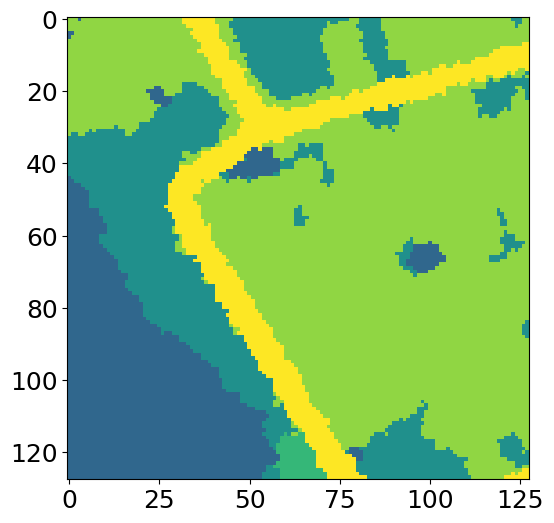

In [8]:
i=0

# Label image
plt.imshow(np.argmax(a.numpy()[i,:,:,:], axis=-1), vmin=0, vmax=6)

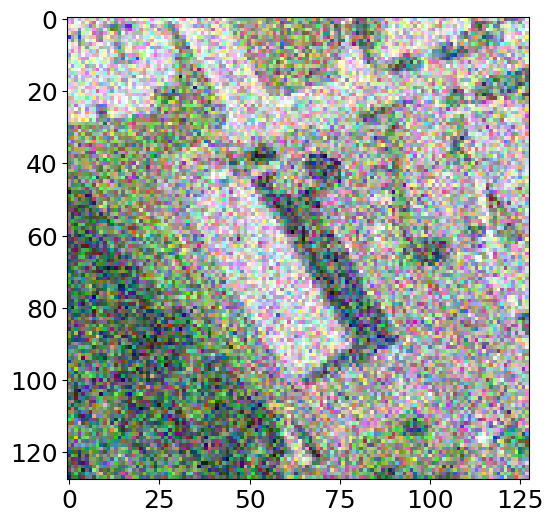

In [9]:
# Noised image
plt.imshow(convert_image(c.numpy()[i,:,:,:]))

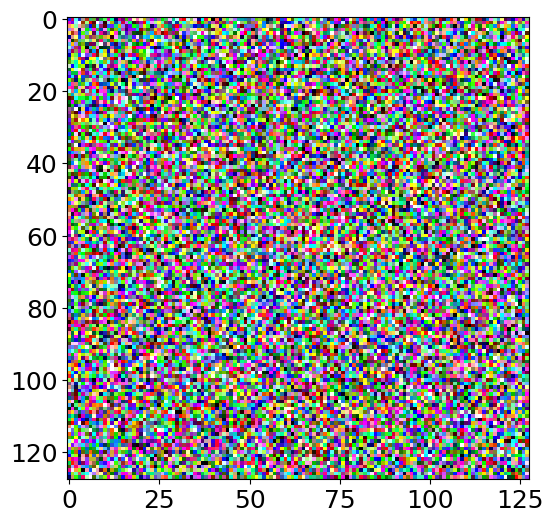

In [10]:
# Noise to predict
plt.imshow(convert_image(d.numpy()[i,:,:,:]))

In [15]:
# For fun: subtract the noise from the image
img = c.numpy()[i,:,:,:] - 0.3*d.numpy()[i,:,:,:]

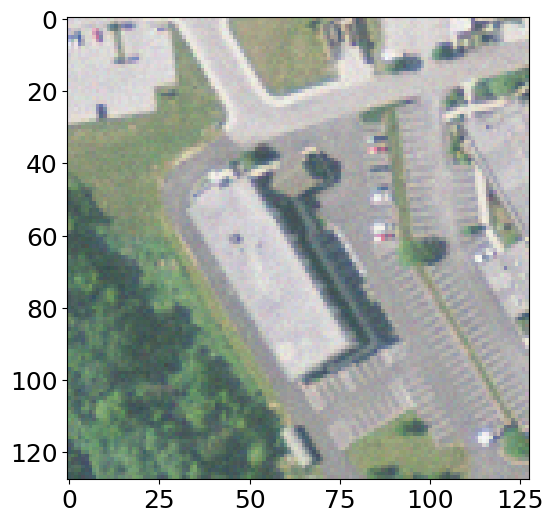

In [16]:
plt.imshow(convert_image(img))

In [17]:
# Timestep indices for each element in the batch
b.numpy()


array([[15],
       [13],
       [18],
       [ 0],
       [ 9],
       [17],
       [ 2],
       [ 0]], dtype=int32)

## Test Positional Encoder

In [18]:
# Create a simple model
input = Input(shape=(1,), dtype=tf.dtypes.int32)
pe = PositionEncoder(20, 30)
tensor = pe(input)
m = Model(inputs=input, outputs=tensor)

In [19]:
# Extract the embedding for visualization
pos = pe.embedding()

([<matplotlib.axis.YTick at 0x7fe3f46d1210>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10'),
  Text(0, 11, '11'),
  Text(0, 12, '12'),
  Text(0, 13, '13'),
  Text(0, 14, '14'),
  Text(0, 15, '15'),
  Text(0, 16, '16'),
  Text(0, 17, '17'),
  Text(0, 18, '18'),
  Text(0, 19, '19')])

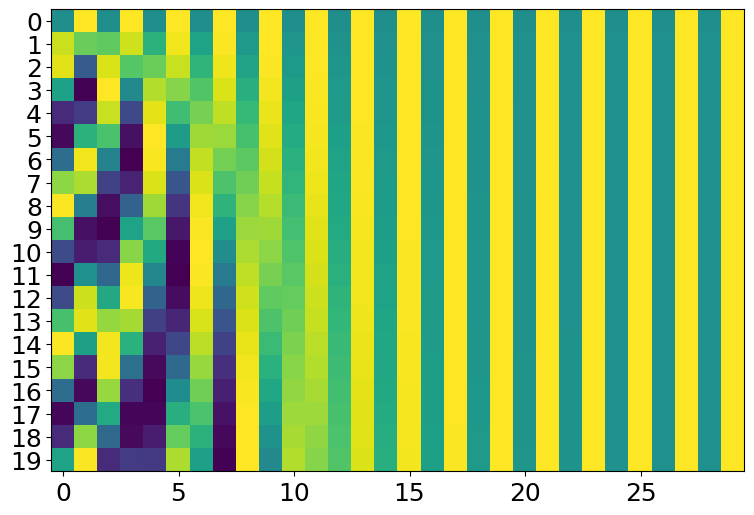

In [20]:
# Display the full embedding
plt.imshow(pos)
plt.yticks(range(20))

In [21]:
# b is the set of indices from the generator
# Test the extraction of the position encoding for each of the elements in the batch
vals = m.predict(b)

1/1 [==============================] - 0s 115ms/step


In [22]:
b.numpy()

array([[15],
       [13],
       [18],
       [ 0],
       [ 9],
       [17],
       [ 2],
       [ 0]], dtype=int32)

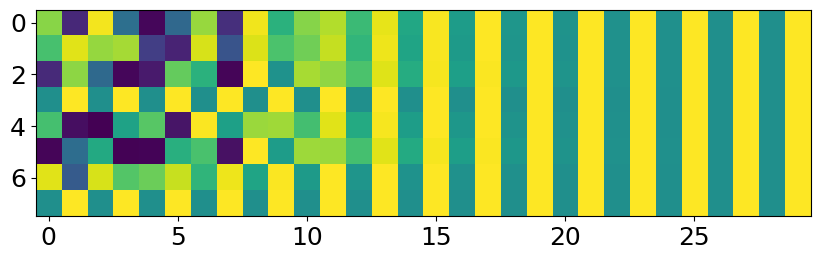

In [23]:
# Each row is the positional embedding for the 8 examples
plt.imshow(vals)

### Expanding a positional embedding
We have one positional embedding for every example.  Now we want to copy this embedding to every pixel.

Note that we are executing this example in __eager mode__, but these tf operators take as input proper TF Tensors and return TF Tensors, so they can be part of the model that you construct.

In [24]:
vals2 = tf.expand_dims( tf.expand_dims(vals, axis=1), axis=1)

In [25]:
vals2.shape

TensorShape([8, 1, 1, 30])

In [26]:
vals3 = tf.tile(vals2, [1,2,3,1])

In [27]:
vals3.shape

TensorShape([8, 2, 3, 30])